<a href="https://colab.research.google.com/github/roboy88/Future-Papal-Conclave-Predictions/blob/main/Pre_Conclave_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving cardinals.csv to cardinals.csv

--- Top 10 Predicted Cardinals ---

                      Name                Country                                          Office  Simulated_Probability
            Pietro Parolin                  Italy              Secretary of State of His Holiness                   0.65
           Chibly Langlois                  Haiti                             Bishop of Les Cayes                   0.05
       Gérald Lacroix ISPX                 Canada                            Archbishop of Quebec                   0.05
        Désiré Tsarahazana             Madagascar                         Archbishop of Toamasina                   0.03
           Fernando Filoni                  Italy Grand Master of the Order of the Holy Sepulchre                   0.00
      Louis Raphaël I Sako                   Iraq         Patriarch of Baghdad\n(Chaldean Church)                   0.00
Robert Francis Prevost OSA          United States            Prefect of the Di

<ipython-input-1-a33837a5b707>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Simulated_Probability', y='Name', data=top_df, palette='Blues_d')


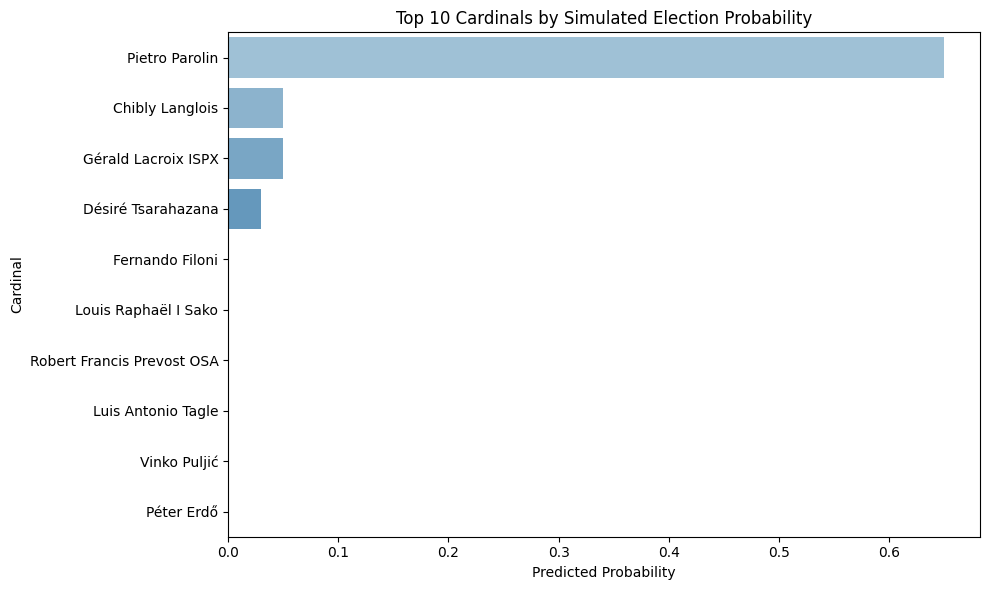


--- Top 10 Countries by Average Election Probability ---

Country
Haiti                     0.050
Italy                     0.038
Madagascar                0.030
Canada                    0.017
Algeria[l]                0.000
Bosnia and Herzegovina    0.000
Argentina                 0.000
Belgium                   0.000
Australia[n]              0.000
Canada[p]                 0.000
Name: Simulated_Probability, dtype: float64


In [1]:
# Install dependencies
!pip install -q pandas scikit-learn matplotlib seaborn

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from google.colab import files

# Upload dataset
uploaded = files.upload()
df = pd.read_csv("cardinals.csv")

# Add simulated election labels
df["Elected_Pope"] = 0
df.loc[df["Name"].str.contains("Prevost", case=False, na=False), "Elected_Pope"] = 0

# Ensure at least one positive label to avoid single-class error
if df["Elected_Pope"].sum() == 0:
    df.at[0, "Elected_Pope"] = 1

# Feature engineering
df['Age'] = df['Age'].astype(str).str.extract(r'(\d+)').astype(float)
df['Year_of_Consistory'] = pd.to_datetime(df['Date_of_consistory'], errors='coerce').dt.year
df['Years_as_Cardinal'] = 2025 - df['Year_of_Consistory']
df['Is_Ukraine'] = df['Country'].str.contains("Ukraine", case=False).astype(int)
df['Is_Latin_America'] = df['Country'].isin(["Brazil", "Mexico", "Argentina", "Colombia", "Peru", "Chile"]).astype(int)
df['Is_Africa'] = df['Country'].isin(["Nigeria", "Congo", "South Africa", "Kenya", "Ghana"]).astype(int)
df["Is_Eastern_Rite"] = df["Office"].str.contains("Eparch|Archeparch", case=False, na=False).astype(int)
df["Is_Ukrainian_Born"] = df["Name"].str.contains("Bychok|Shevchuk|Lubomyr|Sviatoslav|Borys", case=False, na=False).astype(int)
df[['Age', 'Years_as_Cardinal']] = df[['Age', 'Years_as_Cardinal']].fillna(0)

# Model setup
features = [
    'Age', 'Years_as_Cardinal',
    'Is_Ukraine', 'Is_Latin_America', 'Is_Africa',
    'Is_Eastern_Rite', 'Is_Ukrainian_Born'
]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(df[features], df['Elected_Pope'])
df['Simulated_Probability'] = model.predict_proba(df[features])[:, 1]

# Display top 10 predicted papal candidates
top_df = df[['Name', 'Country', 'Office', 'Simulated_Probability']].sort_values(
    by='Simulated_Probability', ascending=False).head(10)

print("\n--- Top 10 Predicted Cardinals ---\n")
print(top_df.to_string(index=False))

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Simulated_Probability', y='Name', data=top_df, palette='Blues_d')
plt.title("Top 10 Cardinals by Simulated Election Probability")
plt.xlabel("Predicted Probability")
plt.ylabel("Cardinal")
plt.tight_layout()
plt.show()

# Average probability by country
region_summary = df.groupby("Country")["Simulated_Probability"].mean().sort_values(ascending=False).head(10)
print("\n--- Top 10 Countries by Average Election Probability ---\n")
print(region_summary.round(3))
